# Introduction


New York City attracts almost one-third of all foreign visitors to the United States. It attracts almost 47 million foreign and American tourists each year. For tourists, the most fun activity is to eat and finding the right place to eat can be a challenge. Many restuarants aim to attract most tourists to their restaurants so if someone is looking to open a restaurant in NYC, the location plays a vital role. Therefore, the purpose of this project is to determine which neighbourhood of New York is best for opening a particular type of restuarant.  

## Table of Contents

1. Installing and Importing Python Libraries and Dependencies <br />
2. Download and Explore Dataset <br />
3. Map of Brooklyn <br />
4. Define Foursquare Credentials and Version <br />
5. Explore Neighborhoods in Brooklyn <br />
6. Analyze Each Neighborhood <br />
7. Cluster Neighborhoods <br />
8. Examine Clusters <br />


## 1. Installing and Importing Python Libraries and Dependencies

In [1]:
!pip install geocoder
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [66]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline
# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2. Download and Explore Dataset

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

In [4]:
# Next, let's load the data.
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [6]:
neighborhoods_data = newyork_data['features']

In [7]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [9]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [10]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [11]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [13]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [14]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### New York City is composed of five boroughs: The Bronx, Brooklyn, Manhattan, Queens, and Staten Island.
For simplicity, let's consider all Neighbourhoods in Brooklyn.

In [15]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()
brooklyn_data.shape

(70, 4)

There are 70 neighbourhoods in Brooklyn and now we will comapare these neighbourhoods. <br/>
Let's get the geographical coordinates of Brooklyn.

In [16]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Brooklyn are 40.6501038, -73.9495823.


### 3. Map of Brooklyn

In [17]:
# create map of brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

### 4. Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'ZBYXE2DZWZS01UBFBLTPXQHD2G4ZO1LUXYFRPINPI1VE4IMA' # your Foursquare ID
CLIENT_SECRET = 'M02FFKYICPBOBJQJAGXX2CLACFLGTFYFRK1PLMMMAE50QA4P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZBYXE2DZWZS01UBFBLTPXQHD2G4ZO1LUXYFRPINPI1VE4IMA
CLIENT_SECRET:M02FFKYICPBOBJQJAGXX2CLACFLGTFYFRK1PLMMMAE50QA4P


#### Let's explore the first neighborhood in our dataframe.

In [19]:
brooklyn_data.loc[0, 'Neighborhood']

'Bay Ridge'

In [20]:
neighborhood_latitude = brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bay Ridge are 40.625801065010656, -74.03062069353813.


#### Now, let's get the top 100 venues that are in Bay Ridge within a radius of 500 meters.

In [21]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [22]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6085494bddfb711b1a030661'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Ridge',
  'headerFullLocation': 'Bay Ridge, Brooklyn',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 84,
  'suggestedBounds': {'ne': {'lat': 40.63030106951066,
    'lng': -74.02470273356597},
   'sw': {'lat': 40.62130106051065, 'lng': -74.03653865351028}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b895827f964a5206c2d32e3',
       'name': 'Pilo Arts Day Spa and Salon',
       'location': {'address': '8412 3rd Ave',
        'lat': 40.62474788273414,
        'lng': -74.03059056940135,
        'labeledLatL

In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [24]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Pilo Arts Day Spa and Salon,Spa,40.624748,-74.030591
1,Bagel Boy,Bagel Shop,40.627896,-74.029335
2,Georgian Dream Cafe and Bakery,Caucasian Restaurant,40.625586,-74.030196
3,Leo's Casa Calamari,Pizza Place,40.624200,-74.030931
4,Ho' Brah Taco Joint,Taco Place,40.622960,-74.031371


In [25]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

84 venues were returned by Foursquare.


<a id='item2'></a>

## 5. Explore Neighborhoods in Brooklyn

#### Let's create a function to repeat the same process to all the neighborhoods in Brooklyn

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [28]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(2728, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Georgian Dream Cafe and Bakery,40.625586,-74.030196,Caucasian Restaurant
3,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


In [29]:
brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,48,48,48,48,48,48
Bay Ridge,84,84,84,84,84,84
Bedford Stuyvesant,31,31,31,31,31,31
Bensonhurst,32,32,32,32,32,32
Bergen Beach,7,7,7,7,7,7
Boerum Hill,88,88,88,88,88,88
Borough Park,21,21,21,21,21,21
Brighton Beach,43,43,43,43,43,43
Broadway Junction,15,15,15,15,15,15


In [30]:
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 299 uniques categories.


In [31]:
brooklyn_restaurants = brooklyn_venues[brooklyn_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
print(brooklyn_restaurants['Venue Category'].value_counts())

Italian Restaurant                 66
Chinese Restaurant                 56
Mexican Restaurant                 45
American Restaurant                39
Caribbean Restaurant               38
Japanese Restaurant                27
Restaurant                         26
Sushi Restaurant                   25
Thai Restaurant                    25
Seafood Restaurant                 24
Fast Food Restaurant               23
Latin American Restaurant          19
Middle Eastern Restaurant          18
French Restaurant                  18
Indian Restaurant                  16
Vegetarian / Vegan Restaurant      12
Mediterranean Restaurant           10
Asian Restaurant                   10
Vietnamese Restaurant              10
Korean Restaurant                   9
New American Restaurant             9
Spanish Restaurant                  9
Greek Restaurant                    7
Ramen Restaurant                    7
Southern / Soul Food Restaurant     6
Russian Restaurant                  5
South Americ

In [32]:
print("There are {} restaurants in Brooklyn".format(brooklyn_restaurants.shape[0]))
print('There are {} unique categories.'.format(len(brooklyn_restaurants['Venue Category'].unique())))

There are 624 restaurants in Brooklyn
There are 58 unique categories.


<a id='item3'></a>

## 6. Analyze Each Neighborhood

In [33]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

brooklyn_onehot.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,North Indian Restaurant,Pakistani Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Bay Ridge,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bay Ridge,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,North Indian Restaurant,Pakistani Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Bath Beach,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.166667,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.111111,0.00,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000
1,Bay Ridge,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.074074,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.037037,0.00,0.000000,0.000000,0.111111,0.000000,0.000000,0.037037,0.000000,0.185185,0.000000,0.000000,0.0,0.000000,0.037037,0.037037,0.074074,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.037037,0.000000
2,Bedford Stuyvesant,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bensonhurst,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.181818,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Boerum Hill,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.200000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,0.066667,0.066667,0.0,0.000000,0.000000,0.066667,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000
5,Borough Park,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

#### Let's print each neighborhood along with the top 5 categories

In [35]:
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                  venue  freq
0    Chinese Restaurant  0.17
1      Sushi Restaurant  0.11
2  Fast Food Restaurant  0.11
3  Cantonese Restaurant  0.11
4    Italian Restaurant  0.11


----Bay Ridge----
                 venue  freq
0   Italian Restaurant  0.19
1  American Restaurant  0.11
2     Greek Restaurant  0.11
3   Chinese Restaurant  0.07
4     Sushi Restaurant  0.07


----Bedford Stuyvesant----
                       venue  freq
0        Japanese Restaurant  0.33
1         Italian Restaurant  0.33
2    New American Restaurant  0.33
3        American Restaurant  0.00
4  Latin American Restaurant  0.00


----Bensonhurst----
                    venue  freq
0      Chinese Restaurant  0.45
1      Italian Restaurant  0.18
2        Sushi Restaurant  0.18
3  Shabu-Shabu Restaurant  0.09
4       Hotpot Restaurant  0.09


----Boerum Hill----
                       venue  freq
0          French Restaurant  0.20
1  Middle Eastern Restaurant  0.13
2       Caribbean Restauran

                      venue  freq
0          Sushi Restaurant   1.0
1       American Restaurant   0.0
2    Shabu-Shabu Restaurant   0.0
3  Mediterranean Restaurant   0.0
4        Mexican Restaurant   0.0


----Paerdegat Basin----
                       venue  freq
0           Asian Restaurant   1.0
1        American Restaurant   0.0
2        Shanghai Restaurant   0.0
3         Mexican Restaurant   0.0
4  Middle Eastern Restaurant   0.0


----Park Slope----
                   venue  freq
0     Italian Restaurant  0.15
1     Mexican Restaurant  0.15
2    American Restaurant  0.08
3  Vietnamese Restaurant  0.08
4       Ramen Restaurant  0.08


----Prospect Heights----
                             venue  freq
0               Mexican Restaurant  0.17
1                       Restaurant  0.10
2                  Thai Restaurant  0.10
3  Southern / Soul Food Restaurant  0.07
4          New American Restaurant  0.07


----Prospect Lefferts Gardens----
                  venue  freq
0  Caribbean R

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Chinese Restaurant,Italian Restaurant,Cantonese Restaurant,Fast Food Restaurant,Sushi Restaurant,Asian Restaurant,German Restaurant,Peruvian Restaurant,Middle Eastern Restaurant,Turkish Restaurant
1,Bay Ridge,Italian Restaurant,American Restaurant,Greek Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Vietnamese Restaurant,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant
2,Bedford Stuyvesant,Italian Restaurant,New American Restaurant,Japanese Restaurant,Eastern European Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Hotpot Restaurant,Shabu-Shabu Restaurant,Eastern European Restaurant,Israeli Restaurant,Indian Restaurant,Hawaiian Restaurant,Greek Restaurant
4,Boerum Hill,French Restaurant,Middle Eastern Restaurant,Korean Restaurant,Caribbean Restaurant,Japanese Restaurant,Indian Restaurant,Mexican Restaurant,Seafood Restaurant,Chinese Restaurant,Italian Restaurant


<a id='item4'></a>

## 7. Cluster Neighborhoods

In [51]:
# set number of clusters (I choose 5)
kclusters = 5

brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 4, 0, 4, 0, 1, 0, 4, 0, 1, 0, 0, 0, 0, 1, 3, 0, 4, 0, 0,
       4, 2, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0, 1, 0, 0, 4, 0, 0, 2],
      dtype=int32)

In [53]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()
brooklyn_merged = brooklyn_data

brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
brooklyn_merged = brooklyn_merged.dropna()

In [54]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 8. Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [50]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Italian Restaurant,American Restaurant,Greek Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Vietnamese Restaurant,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant
2,Sunset Park,Latin American Restaurant,Mexican Restaurant,Italian Restaurant,Chinese Restaurant,Ethiopian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
3,Greenpoint,French Restaurant,Mexican Restaurant,Restaurant,Polish Restaurant,Szechuan Restaurant,Indian Restaurant,American Restaurant,Vietnamese Restaurant,Japanese Restaurant,Italian Restaurant
4,Gravesend,Italian Restaurant,Chinese Restaurant,Eastern European Restaurant,Yemeni Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
5,Brighton Beach,Russian Restaurant,Eastern European Restaurant,Restaurant,Sushi Restaurant,Seafood Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
6,Sheepshead Bay,Turkish Restaurant,American Restaurant,Russian Restaurant,Restaurant,Italian Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
7,Manhattan Terrace,Sushi Restaurant,Japanese Restaurant,Yemeni Restaurant,Eastern European Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
11,Kensington,Thai Restaurant,Mexican Restaurant,Japanese Restaurant,Yemeni Restaurant,Eastern European Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
12,Windsor Terrace,American Restaurant,Sushi Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Italian Restaurant,Brazilian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant
13,Prospect Heights,Mexican Restaurant,Thai Restaurant,Restaurant,New American Restaurant,Southern / Soul Food Restaurant,Korean Restaurant,Vietnamese Restaurant,North Indian Restaurant,Latin American Restaurant,Italian Restaurant


Cluster 1 could be called Italian Cluster.

#### Cluster 2

In [55]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Flatbush,Caribbean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Yemeni Restaurant,Ethiopian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
27,Starrett City,American Restaurant,Caribbean Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
28,Canarsie,Asian Restaurant,Thai Restaurant,Caribbean Restaurant,Yemeni Restaurant,Eastern European Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
32,Coney Island,Caribbean Restaurant,Yemeni Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
64,Broadway Junction,Caribbean Restaurant,Yemeni Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
69,Erasmus,Caribbean Restaurant,Yemeni Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant


Cluster 2 could be called American Carribean and Yemeni Cluster.

#### Cluster 3

In [56]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,East New York,Caribbean Restaurant,Fast Food Restaurant,Yemeni Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
29,Flatlands,Caribbean Restaurant,Fast Food Restaurant,Yemeni Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
47,Prospect Park South,Caribbean Restaurant,Fast Food Restaurant,Latin American Restaurant,Mexican Restaurant,Korean Restaurant,Southern / Soul Food Restaurant,Eastern European Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant
55,Wingate,Fast Food Restaurant,Yemeni Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
57,Remsen Village,Caribbean Restaurant,Fast Food Restaurant,Yemeni Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant


Cluster 3 could be called Carribean Fast Food Cluster.

#### Cluster 4

In [57]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Crown Heights,Kosher Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant


Cluster 4 could be called Diverse Cluster.

#### Cluster 5

In [58]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 4, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bensonhurst,Chinese Restaurant,Italian Restaurant,Sushi Restaurant,Hotpot Restaurant,Shabu-Shabu Restaurant,Eastern European Restaurant,Israeli Restaurant,Indian Restaurant,Hawaiian Restaurant,Greek Restaurant
10,East Flatbush,Chinese Restaurant,Caribbean Restaurant,Fast Food Restaurant,Yemeni Restaurant,Ethiopian Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant
14,Brownsville,Restaurant,Caribbean Restaurant,Spanish Restaurant,Chinese Restaurant,Yemeni Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
34,Borough Park,Fast Food Restaurant,American Restaurant,Chinese Restaurant,Restaurant,Eastern European Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
37,Marine Park,Chinese Restaurant,Yemeni Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
54,Ditmas Park,Chinese Restaurant,Caribbean Restaurant,Mexican Restaurant,Japanese Restaurant,Tibetan Restaurant,Tapas Restaurant,Latin American Restaurant,Ramen Restaurant,French Restaurant,Falafel Restaurant
56,Rugby,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Seafood Restaurant,Yemeni Restaurant,Eastern European Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant
58,New Lots,Asian Restaurant,Chinese Restaurant,Yemeni Restaurant,Ethiopian Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant
63,Weeksville,American Restaurant,Chinese Restaurant,Eastern European Restaurant,Italian Restaurant,Israeli Restaurant,Indian Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant
66,Homecrest,Chinese Restaurant,Mexican Restaurant,American Restaurant,Sushi Restaurant,Russian Restaurant,Asian Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Hawaiian Restaurant,Ethiopian Restaurant


Cluster 5 could be called Chinese Asian Cluster.

# Conclusion

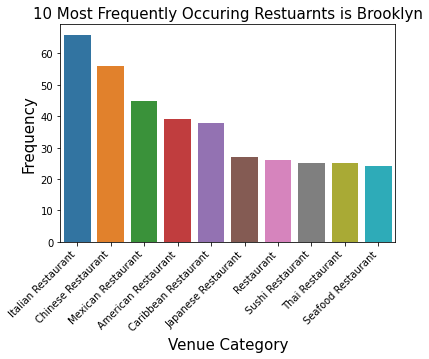

<Figure size 1296x504 with 0 Axes>

In [68]:
brooklyn_top10 = brooklyn_restaurants['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
brooklyn_top10 = brooklyn_top10.reset_index()
brooklyn_top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Cologne_Venues_Top10
s=sns.barplot(x="Venue_Category", y="Frequency", data=brooklyn_top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Restuarnts is Brooklyn', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()